## Universal Approximation Theorem - Gradient Descent Optimisation

Here we study the possibility to approximate functions with a MLP with a single hidden layer (n1 hidden units).
As activation functions, we use the sigmoid ('logit') function.

We generate training data - by assuming a function on the unit interval [0,1]. Here, we provide two families of functions:
* Beta distribution function: $b_{\alpha,\beta}(x)=x^\alpha\cdot(1-x)^\beta$
* Sine function: $sin_\omega(x)=\sin(2\pi\omega\cdot x)$

Finally, we use mini-batch-gradient descent to minimize MSE cost.

Goals:
* Learn how a given function can be represented with a single layer MLP;
* Understand that, in principle, it can be learned from sample data;
* Understand that the optimization based on plain gradient is not always straightforward; 
* Experience that the choice of the hyper-parameters number of hidden units, batchsize, learning rate is tricky. 

In [42]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def plot_function(x,y):
    plt.plot(x, y)
    plt.xlabel('x')
    plt.show()
    
def plot_compare_function(x,y1,y2, label1='', label2=''):
    plt.plot(x, y1, label=label1)
    plt.xlabel('x')
    plt.plot(x, y2, label=label2)
    if label1 and label2:
        plt.legend()
    plt.show()




In [43]:
def beta_fct(x,alpha,beta):
    """
    Parameters:
    x - input array
    alpha, beta -- larger values lead to more pronounced peaks
    """
    c = alpha/(alpha+beta)
    norm = c**alpha*(1-c)**beta
    return x**alpha*(1-x)**beta/norm


def sin_fct(x,omega):
    """
    Parameters:
    x -- input array
    omega -- frequency that defines the integer number of cycles within the unit interval
    """
    return np.sin(x*2*np.pi*omega)


def generate_inputs(m, func, random=True, vargs=None, sigmaY=0.0):
    """
    Generates m (x,y=f(x))-samples by either generating random x-values in the unit interval (random=True) or by 
    generating a grid of such values. Then the y values (used as labels below) are created from the function object 
    `func`.
    Parameter needed to define the function `func` can be passed as vargs-dict. 
    """
    if random:
        x = np.random.rand(1,m)
    else:
        x = np.linspace(0,1,m).reshape(m,1)
    y = func(x,**vargs) + sigmaY*np.random.randn(*(m,1))  
    
    return {'data_x': x, 'data_y':y}

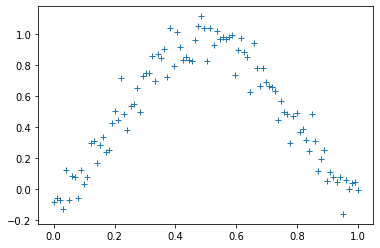

In [44]:
m = 100
func = beta_fct
vargs={'alpha':2.0,'beta':2.0}
#func = sin_fct
#vargs={'omega':1.0}


data = generate_inputs(m,func,vargs=vargs, random=False, sigmaY=0.1)

plt.plot(data['data_x'][:,0], data['data_y'][:,0],'+')

In [45]:
class MiniBatches:
    """
    obtains x- and y-data in the constructor and returns a sample of batch_size with each call to next()
    """
    def __init__(self, x, y, batch_size):
        """
        constructor

        Arguments:
        x/y -- data
        batch_size -- size of batch (0 means one single batch)
        """
        self.x = x
        self.y = y
        m = x.shape[0]
        self.indices = np.arange(m)
        self.n = x.shape[1]
        
        if not batch_size:
            self.batch_size = m
            self.mb = 1
        else:
            self.batch_size = batch_size        
            self.mb = int(m / self.batch_size)    
            np.random.shuffle(self.indices)
        
        self.ib = 0

    def number_of_batches(self):
        return self.mb

    def next(self):
        it = self.indices[self.ib * self.batch_size:(self.ib + 1) * self.batch_size]
        x_batch = self.x[it, :]
        y_batch = self.y[it]
        self.ib += 1

        return {'x_batch': x_batch, 'y_batch': y_batch}

### Class GradientDescent

This class summarises the gradient descent steps. The training and test data is given as dictionary (c.f. cell directly below the class definition for an example). The class can be called, however only a dummy implementation is given (weigths w and bias b are always 0). Replace the dummy parts with your own implementation and test it.

In [46]:
class GradientDescent:
    """
    obtains train and test data in the constructor and does the gradient descend
    """

    def __init__(self, data, alpha=0.1, batch_size=256, num_hidden=15):
        """
        constructor

        Arguments:
        data -- dictionary with data
        alpha -- learning rate
        batch_size -- size of batches to be used
        num_hidden -- number of hidden neurons
        """
        # keep local copy of data
        self.data = data.copy()
        self.alpha = alpha
        self.batch_size = batch_size
        self.num_hidden = num_hidden

        # normalize data
        self.normalise_data()

        # initialize weights and bias 
        self.initialise_weights()

        # result array 
        self.result_data = np.array([])

        
    def normalise_data(self):
        """
        normalize the input data
        """
        # separate normalisation of x and y data
        self.x_norm = {'x_mean': np.mean(self.data['data_x']), 'x_std': np.std(self.data['data_x'])}
        self.y_norm = {'y_mean': np.mean(self.data['data_y']), 'y_std': np.std(self.data['data_y'])}
        
        self.data['data_x'] = (self.data['data_x'] - self.x_norm['x_mean'])/self.x_norm['x_std']
        self.data['data_y'] = (self.data['data_y'] - self.y_norm['y_mean'])/self.y_norm['y_std']
        
        
    def initialise_weights(self):
        """
        initialise weights
        """
        #abbreviation
        n1 = self.num_hidden
        # initialize weights and bias (uniform sampling in [-1,1] plus 'correct' scaling)
        self.w1 = np.random.uniform(-1,1,n1).reshape(1,n1)/(2*np.sqrt(n1))
        self.b1 = np.zeros((1,n1), dtype=float)
        self.w2 = np.random.uniform(-1,1,n1).reshape(n1,1)/(2*np.sqrt(n1))
        self.b2 = 0.0
        
            
    def append_result(self, res_data):
        """
        append cost and error data to output array
        """                  
        if self.result_data.size == 0:
            self.result_data = res_data
        else:
            self.result_data = np.append(self.result_data, res_data, 0)
            
            
    def cost_funct(self, y_pred, y):
        """
        calculates the chosen cost function for given values of w and b
        """
        m = y.shape[0]
        
        ### START YOUR CODE ###

        cost = np.sum((y - y_pred)**2) / (2*m)
        
        ### END YOUR CODE ###

        return cost

    
    def grad_cost(self, y_pred):
        """
        calculates the gradients of cost function wrt w and b
        """
        # abbreviation
        x = self.batch['x_batch']
        y = self.batch['y_batch']
        sig = self.sigmoid(x @ self.w1 + self.b1)
        m = x.shape[0]
        
        ### START YOUR CODE ###
                
        grad_w1 = -self.w2.T / m * np.dot(((y - y_pred)*x).T, sig*(1-sig))
        grad_b1 = -self.w2.T / m * np.dot((y - y_pred).T, sig*(1-sig)) 
        grad_w2 = -1.0 / m * np.dot((y - y_pred).T, sig) 
        grad_b2 = -1.0 / m * np.sum((y - y_pred))
        
        ### END YOUR CODE ###

        return {'grad_w1' : grad_w1, 'grad_b1' : grad_b1, 'grad_w2' : grad_w2.T, 'grad_b2' : grad_b2}

    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    
    def predict(self, x):
        """
        implementation of sigmoid function
        """        
        ### START YOUR CODE ###
        
        y_pred = self.sigmoid(x @ self.w1 + self.b1) @ self.w2 + self.b2
        
        ### END YOUR CODE ###
        
        return y_pred

    
    def update(self):
        """
        performs one gradient descend step
        """
        # predicted outcome for batch
        y_pred = self.predict(self.batch['x_batch'])

        grad = self.grad_cost(y_pred)
        
        ### START YOUR CODE ###
        
        self.w1 = self.w1 - self.alpha*grad['grad_w1']
        self.b1 = self.b1 - self.alpha*grad['grad_b1']
        self.w2 = self.w2 - self.alpha*grad['grad_w2']
        self.b2 = self.b2 - self.alpha*grad['grad_b2']
        
        ### END YOUR CODE ###

        
    def save_results(self, i_step):
        # predicted outcome for entire sample set
        self.y_pred = self.predict(self.data['data_x'])

        # determine cost functions for entire sample set
        self.cost = self.cost_funct(self.y_pred, self.data['data_y'])

        res_data = np.array([[i_step, self.cost]])

        self.append_result(res_data)

        return res_data


    def optimise(self, epochs, debug = False):
        """
        performs epochs number of gradient descend steps and appends result to output array

        Arguments:
        debug -- False (default)/True; get info on each gradient descend step
        """
        # save results before step
        res_data = self.save_results(0)

        for i0 in range(0, epochs):
            # create batches for each epoch
            batches = MiniBatches(self.data['data_x'], self.data['data_y'], self.batch_size)

            for ib in range(batches.number_of_batches()):
                self.batch = batches.next()
                self.update()

            #save data
            res_data = self.save_results(i0+1)

            if debug and np.mod(i0, 1) == 0:
                print('step %r, cost %r' % (i0, res_data[0, 1]))

        print('result after %d epochs: cost %.5f' % (epochs, res_data[0, 1]))
        
        #return unnormalised data
        return self.y_pred*self.y_norm['y_std'] + self.y_norm['y_mean']


### Sample execution of gradient descent

The cell below shows how to use the class GradientDescent to perform the optimisation. The training and test data is given as dictionary in the constructor of the class. Then the method optimise is called with first argument being the number of epochs.


result after 1000 epochs: cost 0.00080


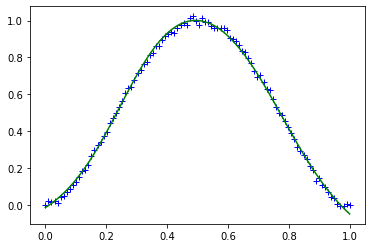

In [112]:
m = 100
func = beta_fct
vargs={'alpha':2.0,'beta':2.0}
#func = sin_fct
#vargs={'omega':1}

data = generate_inputs(m,func,vargs=vargs, random=False, sigmaY=0.01)


gradD = GradientDescent(data, alpha=0.2, batch_size=20, num_hidden=25)

data_y_pred = gradD.optimise(1000, False)

plt.plot(data['data_x'][:,0], data['data_y'][:,0],'b+')
plt.plot(data['data_x'][:,0], data_y_pred[:,0],'g-')

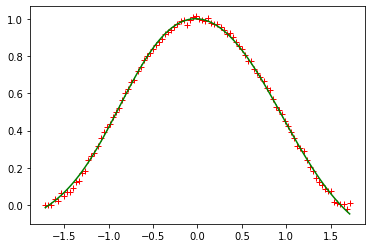

In [113]:
#do analysis for test data
data_test = generate_inputs(m,func,vargs=vargs, random=False, sigmaY=0.01)

#normalise x data
data_test['data_x'] = (data_test['data_x'] - gradD.x_norm['x_mean'])/gradD.x_norm['x_std']
    
#predict and un-normalise
data_test_y_pred = gradD.predict(data_test['data_x'])

data_test_y_pred = data_test_y_pred *gradD.y_norm['y_std'] + gradD.y_norm['y_mean']

plt.plot(data_test['data_x'][:,0], data_test['data_y'][:,0],'r+')
plt.plot(data_test['data_x'][:,0], data_test_y_pred[:,0],'g-')

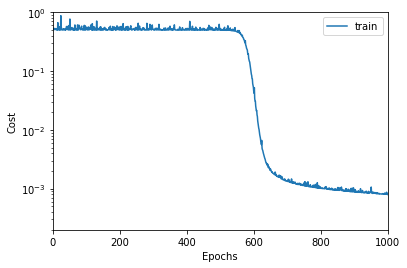

In [114]:
#analyse cost as function of epochs
epochs = gradD.result_data[:,0]
train_costs = gradD.result_data[:,1]


plt.semilogy(epochs, train_costs, label="train")
plt.ylabel('Cost')
plt.xlabel('Epochs')
xmax = epochs[-1]
ymin = 2e-4
ymax = 1
plt.axis([0,xmax,ymin,ymax])
plt.legend()
plt.show() 

# Unit Tests 
### Unit Test for predict

In [9]:
#create dummy instance
data = {'data_x': np.array([[1],[2]]), 'data_y':np.array([[1],[2]])}
gradD = GradientDescent(data, 0.1, 20, 50)

gradD.w1 = np.array([0.4,0.2,-0.4]).reshape(1,3)
gradD.b1 = np.array([0.1,0.1,0.1]).reshape(1,3)
gradD.w2 = np.array([1,2,1]).reshape(3,1)
gradD.b2 = -1
x = np.linspace(-1,1,5).reshape((5,1))
y_pred = gradD.predict(x)
y_exp = np.array([0.99805844, 1.04946333, 1.09991675, 1.14913132, 1.19690185]).reshape(5,1)
np.testing.assert_array_almost_equal(y_pred,y_exp,decimal=8)

### Unit Test for cost
Assumes that Unit Test for predict is correct!

In [10]:
#create dummy instance
data = {'data_x': np.array([[1],[2]]), 'data_y':np.array([[1],[2]])}
gradD = GradientDescent(data, 0.1, 20, 50)

gradD.w1 = np.array([4,5,6]).reshape(1,3)
gradD.b1 = np.array([1,1,1]).reshape(1,3)
gradD.w2 = np.array([1,2,3]).reshape(3,1)
gradD.b2 = 2
x = np.linspace(-1,1,5).reshape(5,1)
y_pred = gradD.predict(x)
y = 2.0*np.ones(5).reshape(5,1)
c = gradD.cost_funct(y_pred, y)
cexp = 9.01669099
np.testing.assert_almost_equal(c,cexp,decimal=8)

### Unit Test for grad_cost
Assumes that Unit Test for predict is correct!

In [11]:
#create dummy instance
data = {'data_x': np.array([[1],[2]]), 'data_y':np.array([[1],[2]])}
gradD = GradientDescent(data, 0.1, 20, 50)

gradD.w1 = np.array([4,5,6]).reshape(1,3)
gradD.b1 = np.array([1,1,1]).reshape(1,3)
gradD.w2 = np.array([1,2,3]).reshape(3,1)
gradD.b2 = 2

x = np.array([1,2,3,4,5,6,7]).reshape((7,1))
y_pred = gradD.predict(x)

y = np.array([2,2,2,2,2,2,2]).reshape((7,1))
gradD.batch = {'x_batch': x, 'y_batch': y}
               
grad = gradD.grad_cost(y_pred)
dw1exp = np.array([0.00590214,0.00427602,0.00234663]).reshape(1,3)
db1exp = np.array([0.00579241,0.004247,0.00234079]).reshape(1,3)
dw2exp = np.array([5.99209251,5.99579451,5.99714226]).reshape(3,1)
db2exp = 5.99792323
np.testing.assert_array_almost_equal(grad['grad_w1'],dw1exp,decimal=8)
np.testing.assert_array_almost_equal(grad['grad_b1'],db1exp,decimal=8)
np.testing.assert_array_almost_equal(grad['grad_w2'],dw2exp,decimal=8)
np.testing.assert_almost_equal(grad['grad_b2'],db2exp,decimal=8)